### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from graphviz import Digraph
from csv import reader
from matplotlib import pyplot as plt

### Class Node

In [2]:
class Node:
  def __init__(self,gini,info_gain, num_samples, num_samples_per_class, predicted_class,number):
        self.number = number
        self.gini = gini
        self.info_gain = info_gain
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

### Decision Tree Functions

In [3]:
class_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'W':9,'X':10,'Y':11}
class_final = ['A','B','C','D','E','F','G','H','I','W','X','Y']
class_attr = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10']
class_attr2 = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10']
max_node_number = 0
class DecisionTree:
    def __init__(self, max_depth=16,attr_list=None):
        self.max_depth = max_depth
        self.attr_list = attr_list
        self.node_count = 0

    def fit(self, X, y,use_info_gain):
        """Build decision tree classifier."""
        self.n_classes_ = len(set(y))  # classes are assumed to go from 0 to n-1
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y,0,self.attr_list,1,use_info_gain)

    def predict(self, X, y_val):
        """Predict class for X."""
        lst = [self._predict(inputs) for inputs in X]
        it =0
        correct = 0
        total = float( len(X))
        for x in y_val:
            if lst[it] == class_dict[x]:
                correct += 1
            it += 1
        accuracy = correct/total
        return lst,accuracy
    
    def _predict(self, inputs):
        """Predict class for a single sample."""
        node = self.tree_
#         print(inputs)
        while node.left:
#             print("Feature ",class_attr[node.feature_index])
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
    
    def debug(self, feature_names, class_names, show_details=True):
        """Print ASCII visualization of decision tree."""
        self.tree_.debug(feature_names, class_names, show_details)

    def _gini(self, y):
        """Compute Gini impurity of a non-empty node.
        Gini impurity is defined as Σ p(1-p) over all classes, with p the frequency of a
        class within the node. Since Σ p = 1, this is equivalent to 1 - Σ p^2.
        """
        m = y.size
        num_parent = [0] * (self.n_classes_)
        for w in y:
            num_parent[class_dict[w]] =  num_parent[class_dict[w]] + 1
            
        # Gini of current node.
        x = 1.0 - sum((n / m) ** 2 for n in num_parent)
        return x
    
    def _info_gain(self,y):
        '''
        Given a Pandas Series, it calculates the entropy. 
          y: variable with which calculate entropy.
          '''
        if isinstance(y, pd.Series):
            a = y.value_counts()/y.shape[0]
            entropy = np.sum(-a*np.log2(a+1e-9))
            return(entropy)

        else:
            raise('Object must be a Pandas Series.')
    
    def _best_split(self, X, y,attr_list = None):
        """Find the best split for a node.
        "Best" means that the average impurity of the two children, weighted by their
        population, is the smallest possible. Additionally it must be less than the
        impurity of the current node.
        To find the best split, we loop through all the features, and consider all the
        midpoints between adjacent training samples as possible thresholds. We compute
        the Gini impurity of the split generated by that particular feature/threshold
        pair, and return the pair with smallest impurity.
        Returns:
            best_idx: Index of the feature for best split, or None if no split is found.
            best_thr: Threshold to use for the split, or None if no split is found.
        """
        # Need at least two elements to split a node.
        m = y.size
        if m <= 1:
            return None, None

        # Count of each class in the current node.

        num_parent = [0] * (self.n_classes_)
        for w in y:
            num_parent[class_dict[w]] =  num_parent[class_dict[w]] + 1
    
        if(use_info_gain == True):
           entropy =  _info_gain(y)
        # Gini of current node.
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        # Loop through all features.
        for idx in range(self.n_features_):
            if class_attr[idx] not in attr_list:   
                continue
            # Sort data along selected feature.
            #print(idx)
            thresholds, classes = zip(*sorted(zip(X.iloc[:, idx], y)))

            # We could actually split the node according to each feature/threshold pair
            # and count the resulting population for each class in the children, but
            # instead we compute them in an iterative fashion, making this for loop
            # linear rather than quadratic.
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
              
                num_left[class_dict[c]] += 1
                num_right[class_dict[c]] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )

                # The Gini impurity of a split is the weighted average of the Gini
                # impurity of the children.
                gini = (i * gini_left + (m - i) * gini_right) / m

                # The following condition is to make sure we don't try to split two
                # points with identical values for that feature, as it is impossible
                # (both have to end up on the same side of a split).
                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2  # midpoint
        
        return best_idx, best_thr
   
    def argmax(self,iterable):
#         return max(enumerate(iterable), key=lambda x: x[1])[0]
        return iterable.index(max(iterable))
    
    def _grow_tree(self, X, y, depth=0,attr_list = None,number = 1,use_info_gain=False):
        """Build a decision tree by recursively finding the best split."""
        # Population for each class in current node. The predicted class is the one with
        # largest population.
        
        num_samples_per_class = [0] * (self.n_classes_ )
        
        for w in y:
            num_samples_per_class[class_dict[w]] =  num_samples_per_class[class_dict[w]] + 1
        

        predicted_class = self.argmax(num_samples_per_class)

        node = Node(
            gini=self._gini(y),
            info_gain=self._info_gain(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
            number = number
        )
        self.node_count = max(self.node_count,number)
        # Split recursively until maximum depth is reached.
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y,attr_list)

            if idx is not None:
                attr_list.pop(attr_list.index(class_attr[idx]))
                indices_left = X.iloc[0:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1,attr_list,number*2,use_info_gain)
                node.right = self._grow_tree(X_right, y_right, depth + 1,attr_list,number*2 +1,use_info_gain)
                attr_list.append(class_attr[idx])
        return node
    
    def restore(self,node, left, right):
        '''
        This function will restore the  children nodes of the current 
        node during the pruning process if you decide not to remove 
        the cchildren of the current node
        Parameters
        ----------
        attr: the attribute of the current node
        left: left child of the current node
        right: right child of the current node 
        '''

        node.left = left
        node.right = right
        
    def count_node(self,node):
        '''
        This function is a helper funcction which is used to recursively 
        count the number of nodes in the tree rooted at the given node 
        Returns
        -------
        num_nodes: this is the number of nodes in the sub tree rooted 
                    at the current node 
        '''
        num_nodes = 1
        if node.left != None:
            num_nodes += self.count_node(node.left)
        if node.right != None:
            num_nodes += self.count_node(node.right)
        return num_nodes

    def remove_children(self,node):
        '''
        This function is a helper function for the pruning step
        the following function removes the children of the current node
        '''
        node.right = None
        node.left = None

  
    def prune(self, decision_tree_root, err, X_valid,y_val):
        '''
        This function is the main pruning function. This function 
        will first recursively prune the children of the current node
        then will decide whether to prune the correct node or not 
        Parameters
        ----------
        decision_tree_root: this is the root of the actual decision tree
                            which is to be pruned and the current node 
                            resides inside the tree rooted at this node
        cur_error:  cur_error stores the current minimum error that can 
                    be achieved by the decision tree rooted at decision 
                    tree root
        X_valid: Validation set of the data that is used for the pruning 
                    achieved
        Returns
        -------
        err: this is the current minimum error that the tree has  
                till now
        '''
        if decision_tree_root.left == None and decision_tree_root.right == None:
            return 10**18
        if decision_tree_root.left != None:
            self.prune(decision_tree_root.left, err, X_valid,y_val)
        if decision_tree_root.right != None:
            self.prune(decision_tree_root.right, err, X_valid,y_val)
        inputs = []
        for i, j in X_valid.iterrows():
            inputs.append(list(j))
     
        # store the data of the children nodes in temporary variable
        temp_left = decision_tree_root.left
        temp_right = decision_tree_root.right

        self.remove_children(decision_tree_root)
        lst, cur_error = self.predict(inputs,y_val)
        cur_error = 1 - cur_error 
        # calculate the error on the new decision tree
        # print(err, cur_error)

        # if the error on the new decision tree increases then
        # restore the children of the current node
        if err < cur_error or self.count_node(decision_tree_root) <= 5:
            self.restore(decision_tree_root, temp_left, temp_right)
        else :
            err = cur_error

In [4]:
def is_leaf(node):
    if node.left==None and node.right==None:
        return True
    return False

In [5]:
def get(node):
    '''
    this function returns a formatted string which will be used 
    for printing the parameters inside the node when the graph 
    is crated using graphviz
    Parameter
    ---------
    node: this is the node object that is to be checked for the leaf
    Return
    -------
    is_leaf: a boolean value which is true when the current node 
                is a leaf
    '''
    if not is_leaf(node):
        return "{} <= {}\n gini= {}\n{}".format(class_attr[node.feature_index], node.threshold, node.gini,node.number)
    return "{}\n{}".format(class_final[node.predicted_class],node.number)

In [6]:
 def print_decision_tree(dtree):
    '''
    this function prints the ddecision tree graph so created 
    and saves the output in the a pdf file 
    Parameter
    ---------
    dtree:  root node of the decision tree for which the 
            the graph needs top be printed
    '''

    # create a new Digraph
    f = Digraph('Decision Tree', filename='decision_tree.gv')
    f.attr(rankdir='LR', size='1000,500')

    # border of the nodes is set to rectangle shape
    f.attr('node', shape='rectangle')

    # Do a breadth first search and add all the edges
    # in the output graph
    q = [dtree]  # queue for the bradth first search
    while len(q) > 0:
        node = q.pop(0)
        if node.left != None:
            f.edge(get(node), get(node.left), label='True')
        if node.right != None:
            f.edge(get(node), get(node.right), label='False')

        if node.left != None:
            q.append(node.left)
        if node.right != None:
            q.append(node.right)

    # save file name :  decision_tree.gv.pdf
    f.render('decision_tree.gv', view=True)

In [7]:

train = pd.read_csv("training_set_avila.csv")
X = train.drop(['Class'],axis = 1)
y = train['Class']
train.describe()

,0,1,2,3,4,5,6,7,8,9
count,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000
mean,0.000852,0.033611,-0.000525,-0.002387,0.006370,0.013973,0.005605,0.010323,0.012914,0.000818
std,0.991431,3.920868,1.120202,1.008527,0.992053,1.126245,1.313754,1.003507,1.087665,1.007094
min,-3.498799,-2.426761,-3.210528,-5.440122,-4.922215,-7.450257,-11.935457,-4.247781,-5.486218,-6.719324
25%,-0.128929,-0.259834,0.064919,-0.528002,0.172340,-0.598658,-0.044076,-0.541991,-0.372457,-0.516097
50%,0.043885,-0.055704,0.217845,0.095763,0.261718,-0.058835,0.220177,0.111803,0.064084,-0.034513
75%,0.204355,0.203385,0.352988,0.658210,0.261718,0.564038,0.446679,0.654944,0.500624,0.530855
max,11.819916,386.000000,50.000000,3.987152,1.066121,53.000000,83.000000,13.173081,44.000000,4.671232


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

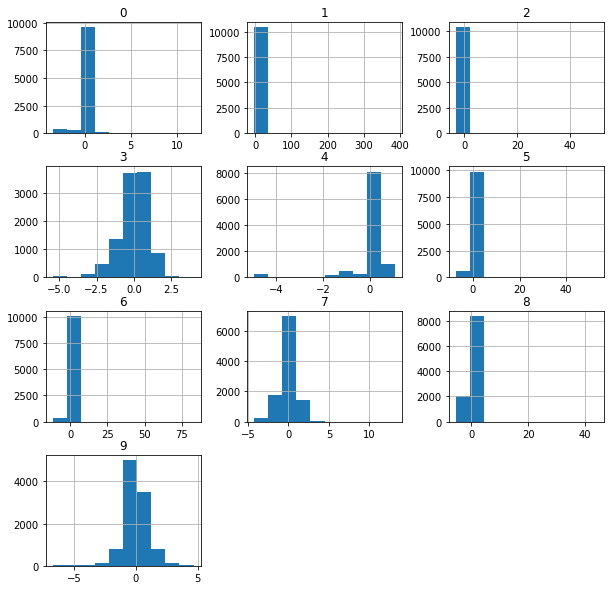

In [8]:
    train.hist(figsize = (10,10))

In [9]:
avg_acc =0
bestTree= None
best_acc = 0.0 
'''
Average over 10 random split with max_depth = 10
'''
use_info_gain = False
max_node_number = 0
for iter in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,shuffle=True)
    attr_list = list(X.columns) 
    clf = DecisionTree(max_depth=15, attr_list = class_attr2)
    clf.fit(X_train, y_train,use_info_gain)
    inputs = []
    for i, j in X_val.iterrows():
        inputs.append(list(j))
    pred,accuracy = clf.predict(inputs,y_val)
    print(iter+1," Accuracy ",accuracy)
    avg_acc+=accuracy
    if best_acc < accuracy:
        bestTree = clf
        best_acc = accuracy

print("average accuracy ",avg_acc/10.0)
print("best accuracy ",best_acc)
bestTree.prune(bestTree.tree_, 1.00 - best_acc , X_val,y_val)
pred,accuracy = bestTree.predict(inputs,y_val)
print("Accuracy after pruning ",accuracy)
# print_decision_tree(bestTree.tree_)


1  Accuracy  0.6356663470757431
2  Accuracy  0.6236816874400767
3  Accuracy  0.6538830297219559
4  Accuracy  0.6514860977948226
5  Accuracy  0.6553211888782359
6  Accuracy  0.6303930968360498
7  Accuracy  0.6447746883988494
8  Accuracy  0.6428571428571429
9  Accuracy  0.6390220517737296
10  Accuracy  0.6490891658676894
average accuracy  0.6426174496644297
best accuracy  0.6553211888782359
Accuracy after pruning  0.6893576222435283


In [10]:
'''
finding the best depth
'''
bestTree= None
best_acc = 0.0
best_depth = 0
avg_acc =0.0
depthToAccuracy = []
NodeCountToAccuracy = []
for depth in range(1,11):
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,shuffle=True)
    attr_list = list(X.columns) 
    clf = DecisionTree(max_depth=depth, attr_list = class_attr2)
    clf.fit(X_train, y_train,use_info_gain)

    inputs = []
    for i, j in X_val.iterrows():
        inputs.append(list(j))
    pred,accuracy = clf.predict(inputs,y_val)
    print("Depth ",depth," Accuracy ",accuracy)
    avg_acc+=accuracy
    depthToAccuracy.append([depth,accuracy])
    NodeCountToAccuracy.append([clf.node_count,accuracy])
    if best_acc < accuracy:
        bestTree = clf
        best_acc = accuracy
        best_depth = depth

print("average accuracy ",avg_acc/12.0)
print("Best Depth ",best_depth," best accuracy ",best_acc)
bestTree.prune(bestTree.tree_, 1.00 - best_acc , X_val,y_val)
pred,accuracy = bestTree.predict(inputs,y_val)
print("Accuracy after pruning the best depth tree ",accuracy)
print_decision_tree(bestTree.tree_)
    

Depth  1  Accuracy  0.475071907957814
Depth  2  Accuracy  0.4865771812080537
Depth  3  Accuracy  0.5225311601150527
Depth  4  Accuracy  0.5599232981783318
Depth  5  Accuracy  0.5944391179290508
Depth  6  Accuracy  0.6112176414189837
Depth  7  Accuracy  0.6395014381591563
Depth  8  Accuracy  0.6332694151486098
Depth  9  Accuracy  0.649568552253116
Depth  10  Accuracy  0.6486097794822627
average accuracy  0.4850591243208693
Best Depth  9  best accuracy  0.649568552253116
Accuracy after pruning the best depth tree  0.6850431447746884


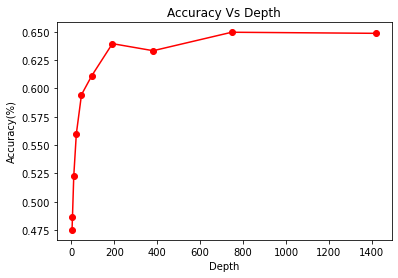

In [11]:
plt.xlabel('Depth')
plt.ylabel('Accuracy(%)')
plt.title("Accuracy Vs Node Count")
plt.plot(
    [x for x,_ in NodeCountToAccuracy],
    [y for _,y in NodeCountToAccuracy],
    marker='o',
    color='red'
)
plt.savefig('question3_2.png')

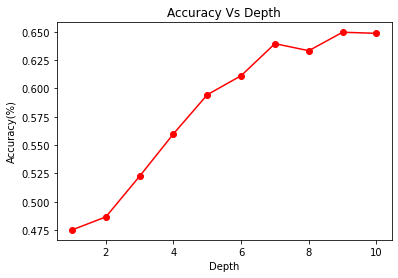

In [12]:
plt.xlabel('Depth')
plt.ylabel('Accuracy(%)')
plt.title("Accuracy Vs Depth")
plt.plot(
    [x for x,_ in depthToAccuracy],
    [y for _,y in depthToAccuracy],
    marker='o',
    color='red'
)
plt.savefig('question3_1.png')